# Room for the river: Gorssel 

## Imports 

In [1]:
#imports
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys

from ema_workbench import (Model, CategoricalParameter,ScalarOutcome, IntegerParameter, RealParameter,
                           MultiprocessingEvaluator, ema_logging, Constant, Policy, Scenario,
                           perform_experiments, SequentialEvaluator,Constraint)
from problem_formulation import get_model_for_problem_formulation

from dike_model_function import DikeNetwork  # @UnresolvedImport

from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress,GenerationalBorg)
from ema_workbench.em_framework.evaluators import (perform_experiments,BaseEvaluator)
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
from ema_workbench.analysis import plotting, plotting_util, parcoords, feature_scoring, prim
from ema_workbench import load_results 

from mpl_toolkits.mplot3d import Axes3D 

from sklearn import preprocessing

import time
import copy

import itertools

from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor
import os
import functools

import random


In [2]:
from scipy.spatial.distance import pdist, squareform

def evaluate_diversity_single(indices, distances, weight=0.5, distance='euclidean'):
    '''
    takes the outcomes and selected scenario set (decision variables), 
    returns a single 'diversity' value for the scenario set.
    outcomes : outcomes dictionary of the scenario ensemble
    decision vars : indices of the scenario set
    weight : weight given to the mean in the diversity metric. If 0, only minimum; if 1, only mean
    '''
    i, j = [e for e in zip(*itertools.combinations(indices, 2))]
    subset_distances = distances[i, j]
    minimum = np.min(subset_distances)
    mean = np.mean(subset_distances)
    diversity = (1-weight)*minimum + weight*mean
    
    return [diversity]


def find_maxdiverse_scenarios(distances, combinations):
    scores = []
    for indices in combinations:
        diversity = evaluate_diversity_single(indices, distances)
        scores.append((diversity, indices))

    return scores

def optimize(scenario, nfe, model, converge_metrics, epsilons):
    with SequentialEvaluator(model) as evaluator:
    #with MultiprocessingEvaluator(model) as evaluator:
        results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                     convergence=convergence_metrics,
                                     epsilons=epsilons,
                                     reference=scenario)
    return results, convergence

def entries_to_remove(entries, the_dict):
    for key in entries:
        if key in the_dict:
            del the_dict[key]

## Create Data 

### Run Model for outcomes and experiments 

In [3]:
#running the model through EMA workbench
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3) 


In [4]:
with SequentialEvaluator(dike_model) as evaluator:
    results_MORDM = evaluator.perform_experiments(scenarios=10, policies=5) 
    #s for number of scenarios, p for number of experiments 
    
experiments_MORDM, outcomes_MORDM = results_MORDM 
#s for number of scenarios, p for number of experiments 

[MainProcess/INFO] performing 10 scenarios * 5 policies * 1 model(s) = 50 experiments
100%|██████████████████████████████████████████| 50/50 [01:03<00:00,  1.28s/it]
[MainProcess/INFO] experiments finished


In [5]:
#save the initial results to be sure the original can be reused without having to run the model again 
raw_outcomes    = outcomes_MORDM.copy()
raw_experiments = experiments_MORDM.copy()

In [6]:
#create dataframes from the dictionaries 

df_experiments = pd.DataFrame(experiments_MORDM)

df_outcomes =pd.DataFrame()
for outcome in outcomes_MORDM.keys():
    df_outcomes[outcome] = outcomes_MORDM[outcome]

df_experiments
df_experiments.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat', 'scenario', 'policy', 'model'],
      dtype='object')

### Load in experiments and outcomes instead of running in this notebook 

In [7]:
df_experiments_s1000_p10 = pd.read_csv("df_experiments_s1000_p10.csv")
df_outcomes_s1000_p10 = pd.read_csv("df_outcomes_s1000_p10.csv")

In [8]:
print(df_experiments_s1000_p10.shape) 
print(df_outcomes_s1000_p10.shape)

(10000, 54)
(10000, 18)


### Set experiments and outcomes 

In [9]:
#for now we choose to run the rest of the notebook with the smaller set of results, as created in this notebook 
experiments = df_experiments#_s1000_p10.copy()
outcomes = df_outcomes#_s1000_p10.copy()


In [10]:
#outcomes.keys()

# Scenario Selection 

### Choose outcomes of interest 

In [11]:
#determine thresholds 

max_expected_annual_damage = 1
#max_dike_investement = 10000
#max_number_deaths = 1 
#max_rfr_costs = 200000
max_evacuation_costs = 5000



In [12]:
outcomes[['A.4_Expected Annual Damage','A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths',
          'RfR Total Costs','Expected Evacuation Costs']]

outcomes_of_interest = outcomes[(outcomes['A.4_Expected Annual Damage']< max_expected_annual_damage) 
                                &( outcomes['Expected Evacuation Costs']<max_evacuation_costs)]

y = (outcomes['A.4_Expected Annual Damage']< max_expected_annual_damage)&( outcomes['Expected Evacuation Costs']<max_evacuation_costs)
#y

In [13]:
outcomes_of_interest.head()
#shape(outcomes_of_interest) 

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0.000000e+00,9.264850e+07,0.000000,6.955678e+06,2.548415e+08,0.001203,0.000000e+00,9.802147e+07,0.000000,0.0,4.973746e+07,0.0,2.210312e+06,3.337712e+07,0.000226,1.607900e+09,456.508362
1,3.006293e+06,9.264850e+07,0.000428,5.803473e+06,2.548415e+08,0.001245,0.000000e+00,9.802147e+07,0.000000,0.0,4.973746e+07,0.0,6.013263e+07,3.337712e+07,0.009310,1.607900e+09,4033.750804
3,0.000000e+00,9.264850e+07,0.000000,0.000000e+00,2.548415e+08,0.000000,0.000000e+00,9.802147e+07,0.000000,0.0,4.973746e+07,0.0,3.729793e+07,3.337712e+07,0.005984,1.607900e+09,2240.150817
4,0.000000e+00,9.264850e+07,0.000000,0.000000e+00,2.548415e+08,0.000000,2.168620e+07,9.802147e+07,0.007059,0.0,4.973746e+07,0.0,2.462285e+07,3.337712e+07,0.002628,1.607900e+09,1936.983097
5,0.000000e+00,9.264850e+07,0.000000,0.000000e+00,2.548415e+08,0.000000,0.000000e+00,9.802147e+07,0.000000,0.0,4.973746e+07,0.0,1.113410e+06,3.337712e+07,0.000143,1.607900e+09,52.229374


In [14]:
experiments.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,129,220.115714,1.0,0.432055,137.468384,1.5,0.075616,206.991501,1.0,0.925798,...,8,8,2,0,0,4,2,5,0,dikesnet
1,89,155.731619,1.0,0.005411,317.474342,1.5,0.109997,275.045766,10,0.574033,...,8,8,2,0,0,4,2,6,0,dikesnet
2,30,274.257183,10,0.608705,221.525634,1.0,0.988634,75.455722,1.5,0.697128,...,8,8,2,0,0,4,2,7,0,dikesnet
3,45,165.162629,1.5,0.246637,103.756301,10,0.756114,287.435445,1.0,0.737117,...,8,8,2,0,0,4,2,8,0,dikesnet
4,96,301.768581,1.0,0.388762,50.885933,1.0,0.589105,116.405067,10,0.031048,...,8,8,2,0,0,4,2,9,0,dikesnet


In [15]:
experiments_of_interest = experiments.loc[y]
outcomes_df = pd.DataFrame({k:v[y] for k,v in outcomes.items()})

#normalize outcomes on unit interval to ensure equal weighting of outcomes
x = outcomes_df.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_outcomes = pd.DataFrame(x_scaled, columns=outcomes_df.columns)

### Create Combinations 

In [16]:
#Question: This cell doesn't run with a large dataframe as input for the outcomes and experiments. 
## How can we fix this? 

# foutmelding: 
#The kernel for Documents/GitHub/EPA1361_group16/MORDM.ipynb appears to have died. It will restart automatically. 

n_scen = experiments.loc[y].shape[0]
indices = range(n_scen)
set_size = 5

n_scen
combinations = itertools.combinations(indices, set_size)
combinations = list(combinations)

In [17]:
sampled_combinations = random.sample(combinations, 100)

In [18]:
distances = squareform(pdist(normalized_outcomes.values))

cores = os.cpu_count()
partial_function = functools.partial(find_maxdiverse_scenarios, distances)


#Difference ProcessPool en ThreadPool 
# https://superfastpython.com/threadpoolexecutor-vs-processpoolexecutor/#Comparison_of_ThreadPoolExecutor_vs_ProcessPoolExecutor
#with ProcessPoolExecutor(max_workers=cores) as executor:

with ThreadPoolExecutor(max_workers=cores) as executor:
    worker_data = np.array_split(combinations, cores)
    results = [e for e in executor.map(partial_function, worker_data)]
    results = list(itertools.chain.from_iterable(results))
    

In [19]:
results.sort(key=lambda entry:entry[0], reverse=True)
most_diverse = results[0]
most_diverse

([2.0789163777549793], array([ 1,  3, 11, 16, 30]))

### create scenarios 

In [20]:
selected = experiments.loc[most_diverse[1], ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat', 'scenario', 'policy', 'model']]
scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]

In [21]:
# Show what the scenarios entail 

# scenarios

In [22]:
keys_notscenario = ['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', 
               '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', 
               '4_RfR 1', '4_RfR 2', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 
              'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 
              'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 
              'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', 
              'EWS_DaysToThreat', 'scenario', 'policy','model']

In [27]:
#create dictionary with only the uncertainties 
for i in range(0,5):
    entries_to_remove(keys_notscenario, scenarios[i]) 

scenario_1 = scenarios[1]
scenario_1

Scenario({'A.0_ID flood wave shape': 45, 'A.1_Bmax': 165.16262872425924, 'A.1_Brate': 1.5, 'A.1_pfail': 0.24663658085316376, 'A.2_Bmax': 103.75630090072444, 'A.2_Brate': 10, 'A.2_pfail': 0.7561141976478244, 'A.3_Bmax': 287.4354451974763, 'A.3_Brate': 1.0, 'A.3_pfail': 0.7371170084973598, 'A.4_Bmax': 196.14242631846378, 'A.4_Brate': 10, 'A.4_pfail': 0.6946697769914885, 'A.5_Bmax': 275.7314536891382, 'A.5_Brate': 1.5, 'A.5_pfail': 0.3903364359512148, 'discount rate 0': 2.5, 'discount rate 1': 4.5, 'discount rate 2': 2.5})

In [28]:
scenarios

[Scenario({'A.0_ID flood wave shape': 89, 'A.1_Bmax': 155.7316190915471, 'A.1_Brate': 1.0, 'A.1_pfail': 0.005411076880621957, 'A.2_Bmax': 317.47434187420214, 'A.2_Brate': 1.5, 'A.2_pfail': 0.10999693247820586, 'A.3_Bmax': 275.04576599372757, 'A.3_Brate': 10, 'A.3_pfail': 0.5740327655286207, 'A.4_Bmax': 60.57185921046759, 'A.4_Brate': 10, 'A.4_pfail': 0.9260702741729357, 'A.5_Bmax': 299.0054163789855, 'A.5_Brate': 10, 'A.5_pfail': 0.20811050210725743, 'discount rate 0': 4.5, 'discount rate 1': 2.5, 'discount rate 2': 2.5}),
 Scenario({'A.0_ID flood wave shape': 45, 'A.1_Bmax': 165.16262872425924, 'A.1_Brate': 1.5, 'A.1_pfail': 0.24663658085316376, 'A.2_Bmax': 103.75630090072444, 'A.2_Brate': 10, 'A.2_pfail': 0.7561141976478244, 'A.3_Bmax': 287.4354451974763, 'A.3_Brate': 1.0, 'A.3_pfail': 0.7371170084973598, 'A.4_Bmax': 196.14242631846378, 'A.4_Brate': 10, 'A.4_pfail': 0.6946697769914885, 'A.5_Bmax': 275.7314536891382, 'A.5_Brate': 1.5, 'A.5_pfail': 0.3903364359512148, 'discount rate 0'

# Create Scenarios for full run 

In [35]:
experiments_full = df_experiments_s1000_p10.copy()
outcomes_full = df_outcomes_s1000_p10.copy()

In [36]:
outcomes_full[['A.4_Expected Annual Damage','A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths',
          'RfR Total Costs','Expected Evacuation Costs']]

outcomes_of_interest_full = outcomes_full[(outcomes_full['A.4_Expected Annual Damage']< max_expected_annual_damage) 
                                &( outcomes_full['Expected Evacuation Costs']<max_evacuation_costs)]

y_full = (outcomes_full['A.4_Expected Annual Damage']< max_expected_annual_damage)&( outcomes_full['Expected Evacuation Costs']<max_evacuation_costs)
#y

In [39]:
experiments_of_interest_full = experiments_full.loc[y_full]
outcomes_df_full = pd.DataFrame({k:v[y_full] for k,v in outcomes_full.items()})

#normalize outcomes on unit interval to ensure equal weighting of outcomes
x_full = outcomes_df_full.values 
min_max_scaler_full = preprocessing.MinMaxScaler()
x_scaled_full = min_max_scaler_full.fit_transform(x_full)
normalized_outcomes_full = pd.DataFrame(x_scaled_full, columns=outcomes_df_full.columns)

In [ ]:
n_scen_full = experiments_full.loc[y_full].shape[0]
indices_full = range(n_scen_full)
set_size = 5

n_scen_full
combinations_full = itertools.combinations(indices_full, set_size)
combinations_full = list(combinations_full)

In [ ]:
sampled_combinations_full = random.sample(combinations_full, 100)

In [ ]:
distances_full = squareform(pdist(normalized_outcomes_full.values))

cores = os.cpu_count()
partial_function_full = functools.partial(find_maxdiverse_scenarios, distances_full)


#Difference ProcessPool en ThreadPool 
# https://superfastpython.com/threadpoolexecutor-vs-processpoolexecutor/#Comparison_of_ThreadPoolExecutor_vs_ProcessPoolExecutor
#with ProcessPoolExecutor(max_workers=cores) as executor:

with ThreadPoolExecutor(max_workers=cores) as executor:
    worker_data_full = np.array_split(combinations_full, cores)
    results_full = [e for e in executor.map(partial_function_full, worker_data_full)]
    results_full = list(itertools.chain.from_iterable(results_full))
    

In [ ]:
results_full.sort(key=lambda entry:entry[0], reverse=True)
most_diverse_full = results_full[0]
most_diverse_full

In [ ]:
selected_full = experiments_full.loc[most_diverse_full[1], ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat', 'scenario', 'policy', 'model']]
scenarios_full = [Scenario(f"{index}", **row) for index, row in selected_full.iterrows()]

In [ ]:
scenarios_full

# Mordm Run 

### Hypervolume determination 

In [31]:
#Question: This cell doesn't work, could you help us? 

ema_logging.log_to_stderr(ema_logging.INFO)

results = []
for scenario in scenarios:
    convergence_metrics = [HyperVolume(minimum=[0,]*len(dike_model.outcomes), 
                                       maximum=[1000,]*len(dike_model.outcomes)),
                           EpsilonProgress()]
    epsilons = [0.1,]*len(dike_model.outcomes)
    
    results.append(optimize(scenario, 100, dike_model, convergence_metrics, epsilons))



  0%|                                                  | 0/100 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]
[MainProcess/INFO] optimization completed, found 97 solutions


  0%|                                                  | 0/100 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]
[MainProcess/INFO] optimization completed, found 92 solutions


  0%|                                                  | 0/100 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 100/100 [02:03<00:00,  1.24s/it]
[MainProcess/INFO] optimization completed, found 96 solutions


  0%|                                                  | 0/100 [00:00<?, ?it/s]

100%|████████████████████████████████████████| 100/100 [02:04<00:00,  1.24s/it]
[MainProcess/INFO] optimization completed, found 86 solutions


  0%|                                                  | 0/100 [00:00<?, ?it/s]

100%|████████████

### Epsilon volume determination 

In [34]:
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(dike_model) as evaluator:
    results1 = evaluator.optimize(nfe=5e3, searchover='levers',
                                  epsilons=[1,]*len(dike_model.outcomes),reference = scenario_1)



  0%|                                                 | 0/5000 [00:00<?, ?it/s]

  2%|▊                                      | 100/5000 [00:26<22:01,  3.71it/s]

  4%|█▌                                     | 197/5000 [00:59<24:42,  3.24it/s]

  6%|██▎                                    | 297/5000 [01:33<25:09,  3.12it/s]

  8%|███                                    | 397/5000 [02:07<25:18,  3.03it/s]

 10%|███▉                                   | 497/5000 [02:42<25:18,  2.97it/s]

 12%|████▋                                  | 597/5000 [03:19<25:37,  2.86it/s]

 14%|█████▍                                 | 697/5000 [03:54<24:58,  2.87it/s]

 16%|██████▏                                | 797/5000 [04:28<24:09,  2.90it/s]

  4%|█▍                                 | 400/10000 [28:18<11:19:21,  4.25s/it]


 20%|███████▊                               | 997/5000 [05:37<23:06,  2.89it/s]

 22%|████████▎                             | 1097/5000 [06:12<22:30,  2.89it/s]

 24%|█████████           

ValueError: cannot convert float NaN to integer

## Plots 

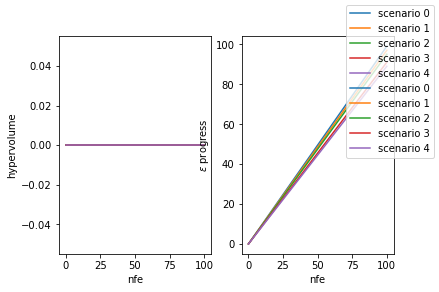

In [33]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

# The part of the notebook below is not of interest for now 

In [ ]:
colors = iter(sns.color_palette())

data = results[0][0].iloc[:, 5::]
limits = parcoords.get_limits(data)

limits.loc[0, ['inertia', 'reliability']] = 1
limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.iloc[:, 5::]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.show()



## Deep Uncertainty 

In [ ]:
#specify the policies 

policies = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 0:5]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)
        
## Our way: 

#Identify policies based on open exploration 

policies = [Policy('policy 1', **{'0_RfR 0':1,
                                  '0_RfR 1':1,
                                  '0_RfR 2':1,
                                  'A.1_DikeIncrease 0':5,
                                 'A.1_DikeIncrease 1':5}),
           Policy('policy 2', **{'4_RfR 0':1,
                                  '4_RfR 1':1,
                                  '4_RfR 2':1,
                                  'A.5_DikeIncrease 0':5}),
           Policy('policy 3', **{'1_RfR 0':1,
                                  '2_RfR 1':1,
                                  '3_RfR 2':1,
                                  'A.3_DikeIncrease 0':5})]
        

In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)

Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.



In [ ]:

experiments, outcomes = reeevaluation_results

#as defined earlier: 
thresholds = {'utility':0.75, 'inertia':0.99, 'reliability':0.8}

overall_scores = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    scores = {}
    for k, v in outcomes.items():
        try:
            n = np.sum(v[logical]>=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

In [ ]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

Alternative way?? 

In [ ]:
overall_scores = {}
regret = []
for scenario in experiments.scenario.unique():
    logical = experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = experiments[experiments.scenario==scenario]
        
    best = temp_results.max()
    best['max_P'] = temp_results.max_P.min()
    scenario_regret = a - best
    scenario_regret['policy'] = temp_experiments.policy.values    
    regret.append(scenario_regret)



In [ ]:
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max()

In [ ]:
limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)
paraxes.plot(maxregret)
plt.show()

## Notes 

In [ ]:
outcomes[['A.4_Expected Annual Damage','A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths',
          'RfR Total Costs','Expected Evacuation Costs']]

In [ ]:
# dike_model.outcomes = [ScalarOutcome('A.4_Expected Annual Damage', kind=ScalarOutcome.MINIMIZE),
#                        ScalarOutcome('A.4_Dike Investment Costs', kind=ScalarOutcome.MINIMIZE),
#                        ScalarOutcome('A.4_Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE),
#                        ScalarOutcome('RfR Total Costs', kind=ScalarOutcome.MINIMIZE),
#                        ScalarOutcome('Expected Evacuation Costs', kind=ScalarOutcome.MINIMIZE)] 

In [ ]:
levers = ['A.0_ID flood wave shape', 
        'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
        'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 
        'A.3_Bmax', 'A.3_Brate', 'A.3_pfail', 
        'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 
        'A.5_Bmax', 'A.5_Brate', 'A.5_pfail', 
          'discount rate 0', 'discount rate 1','discount rate 2', 
          '0_RfR 0', '0_RfR 1', '0_RfR 2', 
          '1_RfR 0','1_RfR 1', '1_RfR 2', 
          '2_RfR 0', '2_RfR 1', '2_RfR 2', 
          '3_RfR 0','3_RfR 1', '3_RfR 2', 
          '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat', 'scenario', 'policy', 'model']



levers_of_interest = ['A.4_Bmax', 'A.4_Brate', 'A.4_pfail',
        '0_RfR 0', '0_RfR 1', '0_RfR 2', 
        '1_RfR 0','1_RfR 1', '1_RfR 2', 
        '2_RfR 0','2_RfR 1', '2_RfR 2', 
        '3_RfR 0','3_RfR 1', '3_RfR 2', 
        '4_RfR 0','4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2']

names_outcomes = ['A.1_Expected Annual Damage', 'A.1_Dike Investment Costs',
       'A.1_Expected Number of Deaths', 'A.2_Expected Annual Damage',
       'A.2_Dike Investment Costs', 'A.2_Expected Number of Deaths',
       'A.3_Expected Annual Damage', 'A.3_Dike Investment Costs',
       'A.3_Expected Number of Deaths', 'A.4_Expected Annual Damage',
       'A.4_Dike Investment Costs', 'A.4_Expected Number of Deaths',
       'A.5_Expected Annual Damage', 'A.5_Dike Investment Costs',
       'A.5_Expected Number of Deaths', 'RfR Total Costs',
       'Expected Evacuation Costs']

In [ ]:
#Identify policies based on open exploration 

# policies = [Policy('policy 1', **{'A.0_ID flood wave shape':, 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
#        'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
#        'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
#        'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
#        'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
#        '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
#        '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
#        'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
#        'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
#        'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
#        'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
#        'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
#        'EWS_DaysToThreat', 'scenario', 'policy', 'model'})]


#            Policy('policy 2', **{'4_RfR 0':1,
#                                   '4_RfR 1':1,
#                                   '4_RfR 2':1,
#                                   'A.5_DikeIncrease 0':5}),
#            Policy('policy 3', **{'1_RfR 0':1,
#                                   '2_RfR 1':1,
#                                   '3_RfR 2':1,
#                                   'A.3_DikeIncrease 0':5})]




Notes van hypervolume en epsilon process 

In [ ]:
# for scenario in scenarios:
#     results_epsilon = evaluator.optimize(scenario, nfe = 5e3 ,searchover='levers',
#                                      epsilons=[0.1,]*len(dike_model.outcomes))

In [ ]:
# #Question: This cell doesn't work, could you help us? 
# ema_logging.log_to_stderr(ema_logging.INFO)

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.optimize(nfe=5000, epsilons=[0.5, 0.5, 0.5, 0.5,0.5])

In [ ]:
# ema_logging.log_to_stderr(ema_logging.INFO)

# for scenario in scenarios:
#     with SequentialEvaluator(dike_model) as evaluator:
#         results1 = evaluator.optimize(,scenario =scenario, nfe=5e3,dike_model ,searchover='levers',
#                                      epsilons=[0.1,]*len(dike_model.outcomes)) 

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)

results = []
for scenario in scenarios:
    #with MultiprocessingEvaluator(dike_model) as evaluator:
    with SequentialEvaluator(dike_model) as evaluator:
        results.append(evaluator.optimize(nfe=5e3, searchover='levers',
                                     epsilons=[0.1,]*len(dike_model.outcomes),reference =scenario)) 

In [ ]:
ema_logging.log_to_stderr(ema_logging.INFO)
for scenario in scenarios: 
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results1 = evaluator.optimize(nfe=5e3, searchover='levers',
                                     epsilons=[0.1,]*len(dike_model.outcomes),reference = scenario)

In [ ]:
# Problem Formulation 

# dike_model.outcomes = [ScalarOutcome('A.4_Expected Annual Damage', kind=ScalarOutcome.MINIMIZE),
#                        ScalarOutcome('A.4_Dike Investment Costs', kind=ScalarOutcome.MINIMIZE),
#                        ScalarOutcome('A.4_Expected Number of Deaths', kind=ScalarOutcome.MINIMIZE),
#                        ScalarOutcome('RfR Total Costs', kind=ScalarOutcome.MINIMIZE),
#                        ScalarOutcome('Expected Evacuation Costs', kind=ScalarOutcome.MINIMIZE)]  

#dike_model.uncertainties 
#dike_model.levers
#dike_model.outcomes

In [ ]:
## Single Scenario MORDM (Assignment 8)

#running the model through EMA workbench
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(3) 


ema_logging.log_to_stderr(ema_logging.INFO)

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results1 = evaluator.optimize(nfe=5e3, searchover='levers',
#                                  epsilons=[0.1,]*len(dike_model.outcomes))
    
with SequentialEvaluator(dike_model) as evaluator:
    results1 = evaluator.optimize(nfe=5e3, searchover='levers',
                                 epsilons=[0.1,]*len(dike_model.outcomes), reference = sce)